In [1]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
plt.title("한글")

NameError: name 'plt' is not defined

In [2]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm
import calendar
import geopandas as gpd
from shapely.geometry import Point
import folium


# 산불 발생 이력 API 연동

- 2020~2024 (5년간)

In [15]:
# 전국 산불 발생 이력 데이터 API 연동

service_key = '4HkFDjyzt0EqUMqeatELHviJQh1D7JxH7b6zDEwhhoJHyC5sNem/thF3LVBmk5909NeRYcLcmxAHxFYFCgWFwg=='
url = 'http://apis.data.go.kr/1400000/forestStusService/getfirestatsservice'

all_items = []

for year in range(2020, 2025):
    for month in range(1, 13):
        searchStDt = f"{year}{month:02}01"
        last_day = calendar.monthrange(year, month)[1]
        searchEdDt = f"{year}{month:02}{last_day}"

        params = {
            'serviceKey': service_key,
            'searchStDt': searchStDt,
            'searchEdDt': searchEdDt,
            'numOfRows': 1000,
            'pageNo': 1
        }

        print(f"📅 {year}-{month:02} 요청 중...")

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"  ❌ 요청 실패: {response.status_code}")
            continue

        root = ET.fromstring(response.content)

        result_code = root.findtext('.//resultCode')
        result_msg = root.findtext('.//resultMsg')
        print(f"  🔍 응답코드: {result_code}, 메시지: {result_msg}")

        items = root.findall('.//item')
        print(f"  📦 받은 item 수: {len(items)}")

        for item in items:
            row = {child.tag: child.text for child in item}
            all_items.append(row)

print(f"✅ 총 데이터 개수: {len(all_items)}")
df = pd.DataFrame(all_items)


📅 2020-01 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 29
📅 2020-02 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 42
📅 2020-03 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 171
📅 2020-04 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 184
📅 2020-05 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 26
📅 2020-06 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 38
📅 2020-07 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 0
📅 2020-08 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 1
📅 2020-09 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 2
📅 2020-10 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 35
📅 2020-11 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 46
📅 2020-12 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 46
📅 2021-01 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 44
📅 2021-02 요청 중...
  🔍 응답코드: 00, 메시지: NORMAL SERVICE.
  📦 받은 item 수: 82
📅 2021-

### 경남 발화원인 집계

In [16]:
df[df['locsi'] == '경남']['firecause'].value_counts()

firecause
입산자실화      92
기타         64
건축물화재비화    35
농산부산물소각    27
담뱃불실화      21
쓰레기소각      20
Name: count, dtype: int64

### 하동+산청 산불 발생 이력 필터링

In [19]:
df['startyear'] = pd.to_numeric(df['startyear'], errors='coerce')

filtered_df = df[
    ((df['locgungu'] == '하동') | (df['locgungu'] == '산청'))
]
filtered_df

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locsi,startday,startdayofweek,startmonth,starttime,startyear,locmenu
56,0.01,08,02,18:30:00,2020,농산부산물소각,산166,하정,산청,경남,08,토요일,02,17:50:00,2020,신안
113,0.05,24,03,02:10:00,2020,입산자실화,산7,문대,산청,경남,23,월요일,03,23:22:00,2020,신안
212,0.01,19,03,22:30:00,2020,담뱃불실화,산65-1,궁항,하동,경남,19,목요일,03,19:49:00,2020,옥종
215,0.02,19,03,19:00:00,2020,기타,산66-1,전대,하동,경남,19,목요일,03,16:30:00,2020,횡천
233,0.02,18,03,16:00:00,2020,건축물화재비화,산47-1,운수,하동,경남,18,수요일,03,13:07:00,2020,화개
657,0.05,04,01,20:00:00,2021,입산자실화,산122,청현,산청,경남,03,일요일,01,13:55:00,2021,신안
699,10,22,02,15:08:00,2021,담뱃불실화,산68-9,미점,하동,경남,21,일요일,02,14:41:00,2021,악양
701,0.5,21,02,14:30:00,2021,기타,산25-1,비파,하동,경남,21,일요일,02,10:45:00,2021,하동
730,0.01,10,02,11:45:00,2021,쓰레기소각,산217,우계,하동,경남,10,수요일,02,10:37:00,2021,적량
732,0.05,09,02,17:20:00,2021,농산부산물소각,산98,우복,하동,경남,09,화요일,02,15:32:00,2021,양보


## 경남 산불 발생 이력 필터링

In [22]:
gn_df = df[
    ((df['locsi'] == '경남'))
]
gn_df.head()

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locsi,startday,startdayofweek,startmonth,starttime,startyear,locmenu
20,0.01,21,01,14:46:00,2020,입산자실화,산106,고례,밀양,경남,21,화요일,01,13:20:00,2020,단장
33,0.02,21,02,16:00:00,2020,담뱃불실화,산47,퇴촌,창원,경남,21,금요일,02,12:44:00,2020,의창
53,0.03,09,02,16:45:00,2020,건축물화재비화,산109,하곡,진주,경남,09,일요일,02,15:48:00,2020,이반성
56,0.01,08,02,18:30:00,2020,농산부산물소각,산166,하정,산청,경남,08,토요일,02,17:50:00,2020,신안
61,0.01,06,02,16:29:00,2020,담뱃불실화,산71-3,금평,통영,경남,06,목요일,02,15:32:00,2020,사량


### 지번 주소 concat

In [20]:
filtered_df['full_location'] = (
    filtered_df['locgungu'].fillna('').astype(str) + '군 ' +
    filtered_df['locmenu'].fillna('').astype(str) + '면 ' +
    filtered_df['locdong'].fillna('').astype(str) + '리 ' +
    filtered_df['locbunji'].fillna('').astype(str)
)

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/515710190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['full_location'] = (


## 산청/하동 발화원인 시각화

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/3467905210.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cause_counts, x='count', y='firecause', palette='Reds_r')


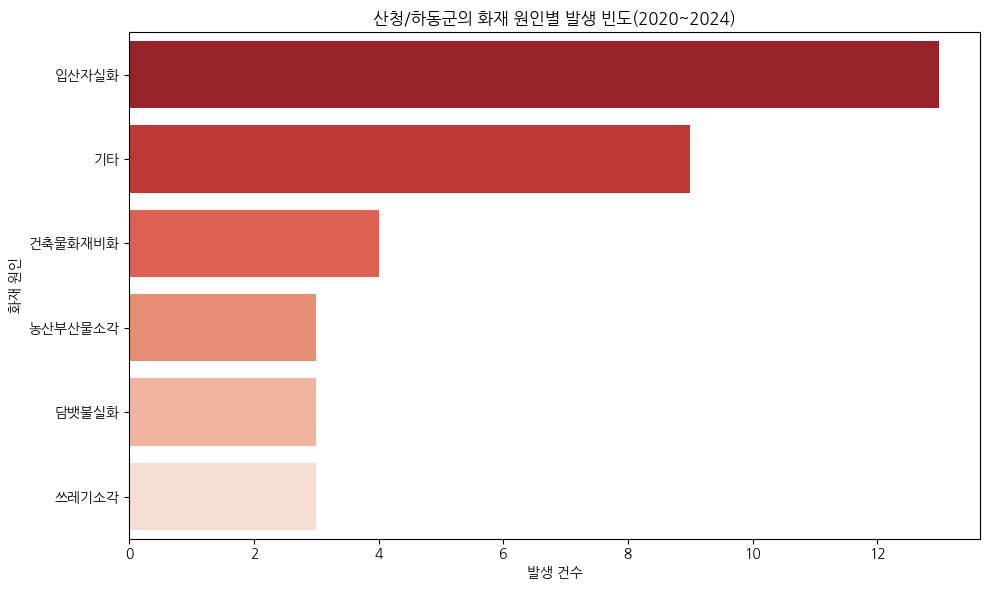

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 빈도수 집계
cause_counts = filtered_df['firecause'].value_counts().reset_index()
cause_counts.columns = ['firecause', 'count']

# 2. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=cause_counts, x='count', y='firecause', palette='Reds_r')
plt.title('산청/하동군의 화재 원인별 발생 빈도(2020~2024)')
plt.xlabel('발생 건수')
plt.ylabel('화재 원인')
plt.tight_layout()
plt.show()

## 경남 발화원인 시각화

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/720104928.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cause_counts, x='count', y='firecause', palette='Blues_r')


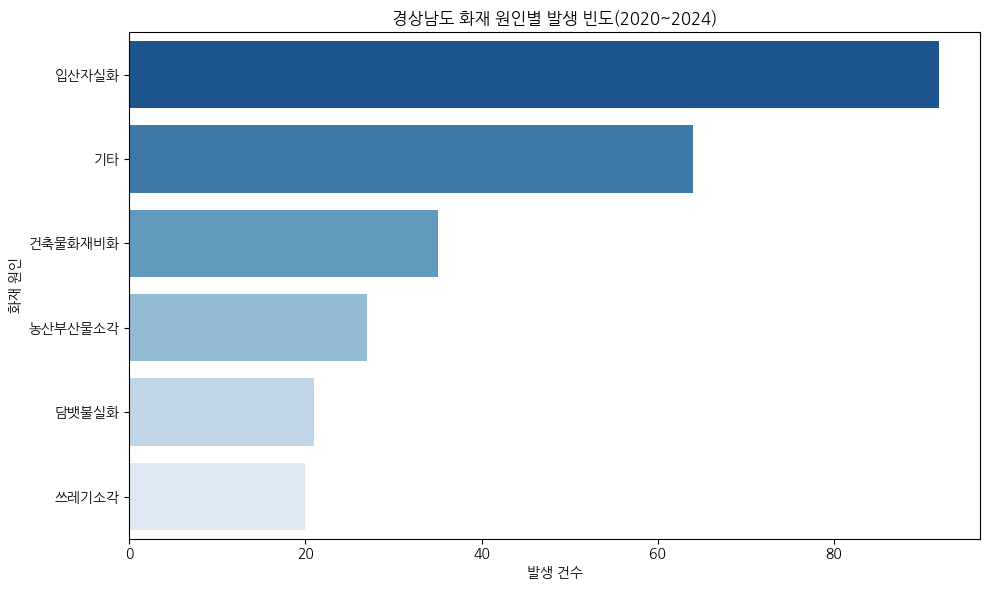

In [31]:
# 1. 빈도수 집계
cause_counts = gn_df['firecause'].value_counts().reset_index()
cause_counts.columns = ['firecause', 'count']

# 2. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=cause_counts, x='count', y='firecause', palette='Blues_r')
plt.title('경상남도 화재 원인별 발생 빈도(2020~2024)')
plt.xlabel('발생 건수')
plt.ylabel('화재 원인')
plt.tight_layout()
plt.show()

In [25]:
filtered_df['firecause'].value_counts()

firecause
입산자실화      13
기타          9
건축물화재비화     4
농산부산물소각     3
담뱃불실화       3
쓰레기소각       3
Name: count, dtype: int64

In [26]:
gn_df['firecause'].value_counts()

firecause
입산자실화      92
기타         64
건축물화재비화    35
농산부산물소각    27
담뱃불실화      21
쓰레기소각      20
Name: count, dtype: int64

In [34]:
filtered_df.head(1)

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locsi,startday,startdayofweek,startmonth,starttime,startyear,locmenu,full_location
56,0.01,08,02,18:30:00,2020,농산부산물소각,산166,하정,산청,경남,08,토요일,02,17:50:00,2020,신안,산청군 신안면 하정리 산166


In [76]:
gn_df

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locsi,startday,startdayofweek,startmonth,starttime,startyear,locmenu,startdate,month,region
20,0.01,21,01,14:46:00,2020,입산자실화,산106,고례,밀양,경남,21,화요일,01,13:20:00,2020,단장,2020-01-21,1,기타
33,0.02,21,02,16:00:00,2020,담뱃불실화,산47,퇴촌,창원,경남,21,금요일,02,12:44:00,2020,의창,2020-02-21,2,기타
53,0.03,09,02,16:45:00,2020,건축물화재비화,산109,하곡,진주,경남,09,일요일,02,15:48:00,2020,이반성,2020-02-09,2,기타
56,0.01,08,02,18:30:00,2020,농산부산물소각,산166,하정,산청,경남,08,토요일,02,17:50:00,2020,신안,2020-02-08,2,산청·하동
61,0.01,06,02,16:29:00,2020,담뱃불실화,산71-3,금평,통영,경남,06,목요일,02,15:32:00,2020,사량,2020-02-06,2,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,0.2,31,08,18:00:00,2024,기타,산77,관지,진주,경남,31,토요일,08,14:54:00,2024,명석,2024-08-31,8,기타
2514,0.1,10,09,18:00:00,2024,기타,52,내이,밀양,경남,10,화요일,09,15:55:00,2024,NaN,2024-09-10,9,기타
2519,0.1,13,10,13:06:00,2024,담뱃불실화,산142-4,삼덕,통영,경남,13,일요일,10,11:02:00,2024,산양,2024-10-13,10,기타
2524,0.3,18,11,19:29:00,2024,입산자실화,산11-1,갈계,거창,경남,18,월요일,11,15:16:00,2024,북상,2024-11-18,11,기타


In [75]:
gn_df.to_csv('경남_산불발생이력_2020~2024.csv')

## startdate 컬럼 생성 및 날짜 형식으로 변경

In [44]:
filtered_df['startdate'] = (
    filtered_df['startyear'].astype(str) + '-' +
    filtered_df['startmonth'].astype(str) + '-' +
    filtered_df['startday'].astype(str)
)
filtered_df.head(1)

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/2073920800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['startdate'] = (


,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locsi,startday,startdayofweek,startmonth,starttime,startyear,locmenu,full_location,starttimestamp,startdate
56,0.01,08,02,18:30:00,2020,농산부산물소각,산166,하정,산청,경남,08,토요일,02,17:50:00,2020,신안,산청군 신안면 하정리 산166,2020-02- 08 17:50:00,2020-02-08


In [ ]:
filtered_df['startdate'] = pd.to_datetime(filtered_df['startdate'])

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/2808029921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['startdate'] = pd.to_datetime(filtered_df['startdate'])


In [46]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 56 to 2395
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   damagearea      35 non-null     object        
 1   endday          35 non-null     object        
 2   endmonth        35 non-null     object        
 3   endtime         35 non-null     object        
 4   endyear         35 non-null     object        
 5   firecause       35 non-null     object        
 6   locbunji        35 non-null     object        
 7   locdong         35 non-null     object        
 8   locgungu        35 non-null     object        
 9   locsi           35 non-null     object        
 10  startday        35 non-null     object        
 11  startdayofweek  35 non-null     object        
 12  startmonth      35 non-null     object        
 13  starttime       35 non-null     object        
 14  startyear       35 non-null     int64         
 15  locmenu   

In [51]:
gn_df['startdate'] = (
    gn_df['startyear'].astype(str) + '-' +
    gn_df['startmonth'].astype(str) + '-' +
    gn_df['startday'].astype(str)
)
gn_df['startdate'] = pd.to_datetime(gn_df['startdate'])

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/222490202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gn_df['startdate'] = (
/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/222490202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gn_df['startdate'] = pd.to_datetime(gn_df['startdate'])


## 월별 시계열 그래프 시각화

/var/folders/wn/fg3vjbj159x6j8g18tzqxpwm0000gn/T/ipykernel_53075/3409363195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['startdate'].dt.month


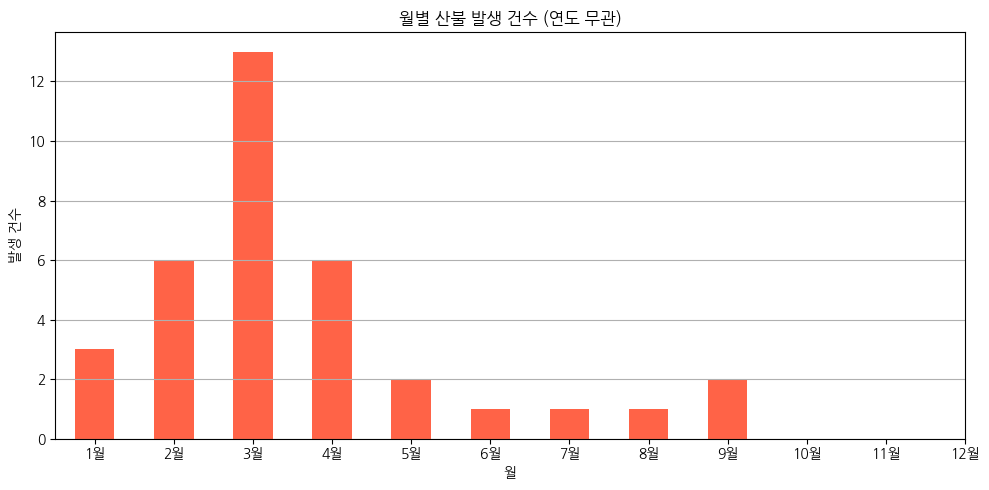

In [ ]:
# 월(Month)만 추출
filtered_df['month'] = filtered_df['startdate'].dt.month

# 월별 산불 발생 건수 집계
monthly_counts = filtered_df['month'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 5))
monthly_counts.plot(kind='bar', color='tomato')
plt.title(' 월별 산불 발생 건수 (연도 무관)')
plt.xlabel('월')
plt.ylabel('발생 건수')
plt.xticks(ticks=range(0, 12), labels=[f'{i}월' for i in range(1, 13)], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 요일별 발생 건수 집계

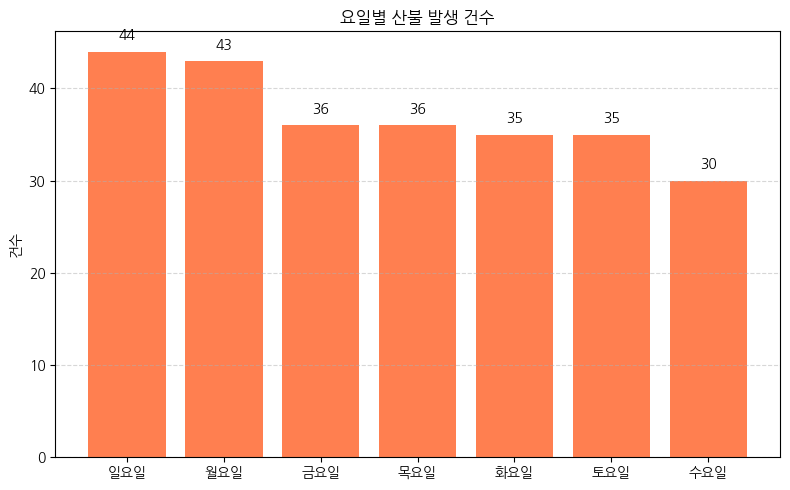

In [62]:
# 1. 요일별 발생 건수 집계
weekday_counts = gn_df['startdayofweek'].value_counts()


# 2. 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(weekday_counts.index, weekday_counts.values, color='coral')

# 3. 막대 위에 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, int(height),
             ha='center', va='bottom', fontsize=10)

plt.title('요일별 산불 발생 건수')
plt.ylabel('건수')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# geoservice 활용 -> 좌표 컬럼 추가된 데이터 불러오기

In [14]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [63]:
gdf = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/산청+하동_5년간산불발생좌표.csv')

In [64]:
gdf.drop('field1', axis=1, inplace=True)

### 컬럼명 변경

In [65]:
new_columns = [
    'damagearea', 'endday', 'endmonth', 'endtime', 'endyear', 'firecause',
    'locbunji', 'locdong', 'locgungu', 'locsi', 'startday', 'startdayofweek',
    'startmonth', 'starttime', 'startyear', 'locmenu', 'full_location'
]
gdf.columns = new_columns + ['GC_TYPE', 'CLEANADDR', 'X', 'Y']


In [66]:
gdf.head()

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locsi,...,startdayofweek,startmonth,starttime,startyear,locmenu,full_location,GC_TYPE,CLEANADDR,X,Y
0,0.01,8,2,18:30:00,2020,농산부산물소각,산166,하정,산청,경남,...,토요일,2,17:50:00,2020,신안,산청군 신안면 하정리 산166,정,경상남도 산청군 신안면 하정리 산 166,127.970234,35.298082
1,0.05,24,3,02:10:00,2020,입산자실화,산7,문대,산청,경남,...,월요일,3,23:22:00,2020,신안,산청군 신안면 문대리 산7,정,경상남도 산청군 신안면 문대리 산 7,127.997928,35.345930
2,0.01,19,3,22:30:00,2020,담뱃불실화,산65-1,궁항,하동,경남,...,목요일,3,19:49:00,2020,옥종,하동군 옥종면 궁항리 산65-1,정,경상남도 하동군 옥종면 궁항리 산 65-1,127.819498,35.202554
3,0.02,18,3,16:00:00,2020,건축물화재비화,산47-1,운수,하동,경남,...,수요일,3,13:07:00,2020,화개,하동군 화개면 운수리 산47-1,정,경상남도 하동군 화개면 운수리 산 47-1,127.663921,35.240547
4,0.02,19,3,19:00:00,2020,기타,산66-1,전대,하동,경남,...,목요일,3,16:30:00,2020,횡천,하동군 횡천면 전대리 산66-1,정,경상남도 하동군 횡천면 전대리 산 66-1,127.832766,35.153261


In [67]:
# 좌표 → Point 형식으로 변환
geometry = [Point(xy) for xy in zip(gdf['X'], gdf['Y'])]

# GeoDataFrame 생성 (위경도 좌표계: EPSG:4326)
fire_gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs='EPSG:4326')


### 버퍼 생성 (1km, 3km, 5km)

In [21]:
# 3. 버퍼 생성을 위해 meter 좌표계로 변환
fire_gdf_meter = fire_gdf.to_crs(epsg=5181)  # Korea TM

# 4. 1km, 3km, 5km 버퍼 생성
buffer_1km = fire_gdf_meter.buffer(1000).to_crs(epsg=4326)
buffer_2km = fire_gdf_meter.buffer(2000).to_crs(epsg=4326)
buffer_3km = fire_gdf_meter.buffer(3000).to_crs(epsg=4326)


### 지도에 시각화 (예: folium)

In [22]:
# 5. folium 지도 생성
center = [fire_gdf.geometry.y.mean(), fire_gdf.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=11)

# 6. 산불 지점 마커 표시
for _, row in fire_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=1
    ).add_to(m)

# 7. 버퍼 각각 지도에 추가 (1km = 파랑, 3km = 주황, 5km = 회색)
colors = ['blue', 'orange', 'gray']
buffers = [buffer_1km, buffer_2km, buffer_3km]
labels = ['1km', '3km', '5km']

for buf, color, label in zip(buffers, colors, labels):
    for geom in buf:
        folium.GeoJson(
            geom,
            style_function=lambda x, col=color: {'color': col, 'weight': 2, 'fillOpacity': 0.1},
            name=f'{label} buffer'
        ).add_to(m)

# 8. 레이어 컨트롤 추가
folium.LayerControl().add_to(m)

# 9. 결과 저장
m.save("fire_buffers_all.html")

In [68]:
# 1. 전체 경남 행정구역 경계 불러오기 (GeoDataFrame)
# 예시 파일 경로: '경남_행정경계.shp'
gdf_admin = gpd.read_file('/Users/joomacbook/Desktop/경남 빅데이터 공모전/LARD_ADM_SECT_SGG_경남/LARD_ADM_SECT_SGG_48_202505.shp')

In [24]:
gdf_admin

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,geometry
0,48121,경상남도 창원시 의창구,10622.0,48120,"POLYGON ((349215.311 309694.213, 349308.607 30..."
1,48123,경상남도 창원시 성산구,NaN,48120,"MULTIPOLYGON (((345338.621 287072.14, 345334.5..."
2,48125,경상남도 창원시 마산합포구,10654.0,48120,"MULTIPOLYGON (((343629.974 275247.393, 343633...."
3,48127,경상남도 창원시 마산회원구,10714.0,48120,"POLYGON ((341729.834 298945.548, 341762.869 29..."
4,48129,경상남도 창원시 진해구,10618.0,48120,"MULTIPOLYGON (((352768.212 274811.909, 352766...."
5,48170,경상남도 진주시,1.0,48170,"POLYGON ((305137.543 306500.038, 305169.107 30..."
6,48220,경상남도 통영시,NaN,48220,"MULTIPOLYGON (((335615.347 212368.078, 335613...."
7,48240,경상남도 사천시,1971.0,48240,"MULTIPOLYGON (((298806.807 255358.43, 298808.6..."
8,48250,경상남도 김해시,355.0,48250,"POLYGON ((370298.949 310714.416, 370298.963 31..."
9,48270,경상남도 밀양시,1.0,48270,"POLYGON ((373731.307 339660.103, 373783.465 33..."


In [25]:
# 1. 지도 객체 생성
m = folium.Map(location=[fire_gdf.geometry.y.mean(), fire_gdf.geometry.x.mean()], zoom_start=10)

# 2. 산불 지점 버퍼 (1km, 3km, 5km)
buffer_distances = [1000, 2000, 3000]  # meters
colors = ['red', 'orange', 'blue']
labels = ['1km', '2km', '3km']

# EPSG:4326 좌표계로 변환
fire_gdf_4326 = fire_gdf.to_crs(epsg=4326)

# 각각의 거리로 버퍼 생성 후 지도에 추가
for dist, color, label in zip(buffer_distances, colors, labels):
    # 원래 좌표계로 버퍼 생성 (미터 단위)
    buffered = fire_gdf.copy()
    buffered = buffered.to_crs(epsg=5186)  # 버퍼 생성을 위한 미터 단위 좌표계
    buffered['geometry'] = buffered.buffer(dist)
    buffered = buffered.to_crs(epsg=4326)  # 다시 folium용 좌표계로

    # GeoJson 추가
    folium.GeoJson(
        buffered,
        style_function=lambda x, col=color: {'color': col, 'weight': 2, 'fillOpacity': 0.1},
        name=f'{label} 버퍼'
    ).add_to(m)

# 3. 산청군·하동군 경계선 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 4. Layer Control 추가
folium.LayerControl().add_to(m)

# 5. 저장 or 출력
m.save('map_with_buffers_and_boundary.html')

## 산불지점 시각화(보고서용)

In [69]:
# 5. folium 지도 생성
center = [fire_gdf.geometry.y.mean(), fire_gdf.geometry.x.mean()]
m = folium.Map(location=[fire_gdf.geometry.y.mean(), fire_gdf.geometry.x.mean()], zoom_start=10)

# 6. 산불 지점 마커 표시
for _, row in fire_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=1
    ).add_to(m)


# EPSG:4326 좌표계로 변환
fire_gdf_4326 = fire_gdf.to_crs(epsg=4326)

# 3. 산청군·하동군 경계선 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동군|산청군')].to_crs(epsg=4326)

folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)


# 5. 저장 or 출력
m.save('산불발생지점.html')

In [71]:
import folium
from folium.features import DivIcon

# 1. 지도 중심 설정
center = [fire_gdf.geometry.y.mean(), fire_gdf.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=10)

# 2. EPSG:4326 변환
fire_gdf_4326 = fire_gdf.to_crs(epsg=4326)
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동|산청')].to_crs(epsg=4326)

# 3. 산불 지점 마커 & 텍스트 표시
for _, row in fire_gdf_4326.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    cause = row['firecause']

    # 원형 마커
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=1
    ).add_to(m)

    # 텍스트 라벨 (firecause)
    folium.map.Marker(
        [lat + 0.002, lon],  # 마커 위 살짝 위로 올림
        icon=DivIcon(
            icon_size=(150, 36),
            icon_anchor=(0, 0),
            html=f'<div style="font-size: 10pt; color: black;">{cause}</div>'
        )
    ).add_to(m)

# 4. 경계선 추가
folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 5. 저장
m.save('산불발생지점.html')

In [73]:
import folium
import seaborn as sns
from folium import Map, CircleMarker, GeoJson
from folium.features import Element

# 1. 고유 firecause 목록과 진한 색상 매핑
firecauses = fire_gdf['firecause'].dropna().unique()
colors = sns.color_palette('Dark2', n_colors=len(firecauses)).as_hex()  # 진한 색
cause_color_map = dict(zip(firecauses, colors))

# 2. 지도 생성
m = folium.Map(location=[fire_gdf.geometry.y.mean(), fire_gdf.geometry.x.mean()], zoom_start=10)

# 3. EPSG:4326 변환
fire_gdf_4326 = fire_gdf.to_crs(epsg=4326)

# 4. 산불 지점 마커 표시
for _, row in fire_gdf_4326.iterrows():
    cause = row['firecause']
    color = cause_color_map.get(cause, 'gray')

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.9
    ).add_to(m)

# 5. 산청/하동 행정경계 추가
gdf_boundary = gdf_admin[gdf_admin['SGG_NM'].str.contains('하동|산청')].to_crs(epsg=4326)
folium.GeoJson(
    gdf_boundary,
    style_function=lambda x: {
        'color': 'green',
        'weight': 3,
        'fillOpacity': 0,
        'dashArray': '5, 5'
    },
    name='행정경계선'
).add_to(m)

# 6. 범례(legend) 추가
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 220px; height: auto; 
            z-index:9999; font-size:14px; 
            background-color: white; padding: 10px; 
            border:2px solid grey; border-radius: 5px;">
<b>🔥 산불 원인 범례</b><br>
"""
for cause, color in cause_color_map.items():
    legend_html += f"""
    <i style="background:{color}; width:12px; height:12px; float:left; margin-right:6px; display:inline-block;"></i>
    {cause}<br>
    """
legend_html += "</div>"

m.get_root().html.add_child(Element(legend_html))

# 7. 저장
m.save('산불발생지점_진한색.html')


# 대형산불위험예보

In [28]:
weather = pd.read_csv("/Users/joomacbook/Desktop/경남 빅데이터 공모전/산림청 국립산림과학원_대형산불위험예보목록정보_20250228.csv", encoding='cp949')

In [29]:
weather

,예보일시,시도명,시군구명,읍면동명,실효습도,풍속,등급
0,2017-01-17 15:00,강원도,인제군,북면,34.6,7.3,주의보
1,2017-01-23 11:00,경상북도,포항시 남구,장기면,30.9,7.3,주의보
2,2017-01-24 14:00,전라남도,여수시,경호동,36.2,7.3,주의보
3,2017-01-27 10:00,경상북도,포항시 북구,기계면,34.2,8.4,주의보
4,2017-01-27 10:00,경상북도,경주시,안강읍,34.1,7.8,주의보
...,...,...,...,...,...,...,...
40396,2025-02-28 13:00,경북,영주,안정면,33.0,8.7,주의보
40397,2025-02-28 13:00,경북,예천,감천면,33.0,7.3,주의보
40398,2025-02-28 13:00,경북,봉화,봉화읍,33.0,7.9,주의보
40399,2025-02-28 13:00,강원,양양,손양면,27.7,11.7,주의보


In [30]:
# 등급이 '주의보'인 행들 중 실효습도의 최소값 구하기
min_value = weather[weather['등급'] == '주의보']['실효습도'].min()
print(min_value)

0.0


In [31]:
# 등급이 '주의보'인 행들 중 풍속의 최소값 구하기
min_value = weather[weather['등급'] == '주의보']['풍속'].min()
print(min_value)

7.0


In [32]:
weather.groupby('등급')[['실효습도', '풍속']].agg(['min', 'max', 'mean'])


실효습도                     풍속                 
      min   max       mean   min   max       mean
등급                                               
경보   34.9  34.9  34.900000  11.7  11.7  11.700000
주의보   0.0  52.6  36.533384   7.0  74.8   8.002049

In [33]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '한글')

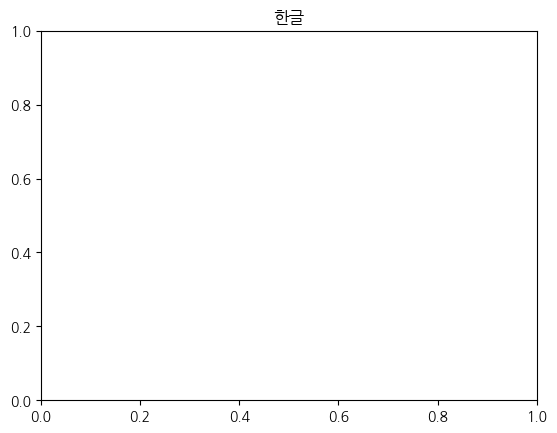

In [34]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
plt.title("한글")

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

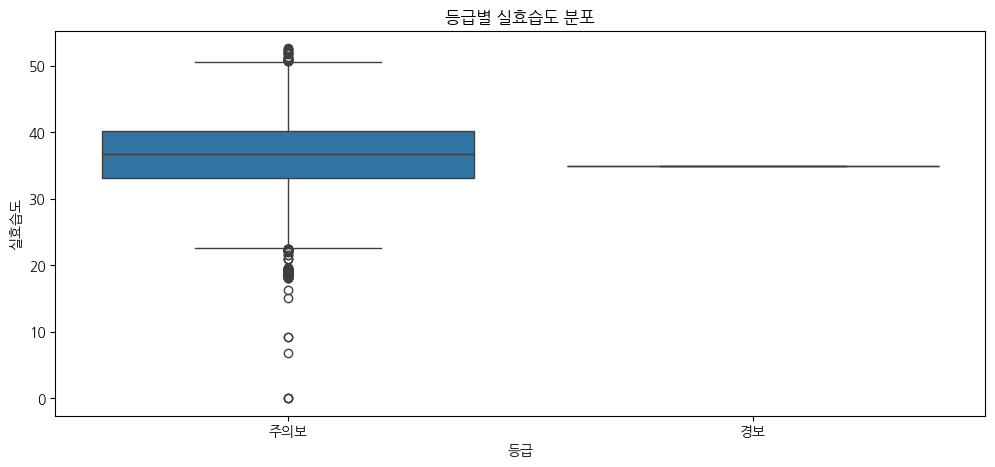

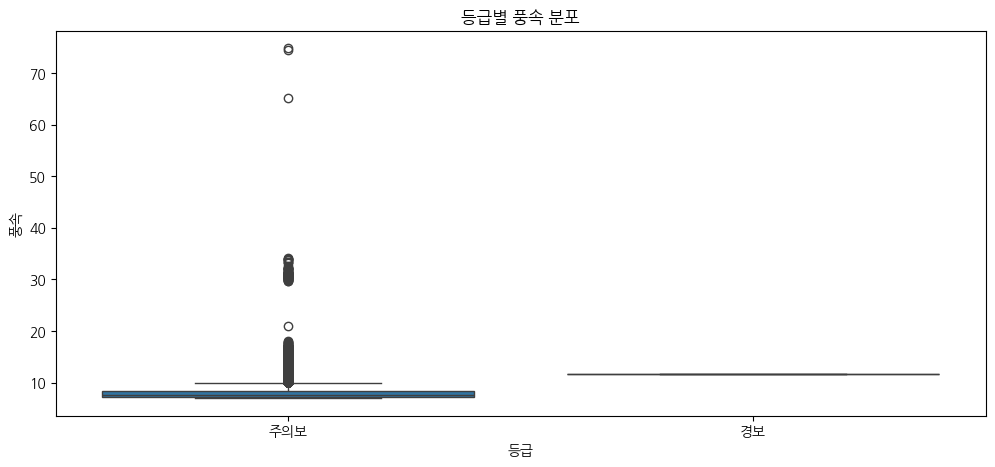

In [36]:
# 실효습도 분포
plt.figure(figsize=(12, 5))
sns.boxplot(data=weather, x='등급', y='실효습도')
plt.title('등급별 실효습도 분포')
plt.show()

# 풍속 분포
plt.figure(figsize=(12, 5))
sns.boxplot(data=weather, x='등급', y='풍속')
plt.title('등급별 풍속 분포')
plt.show()

In [37]:
weather.query('등급 == "경보"')

,예보일시,시도명,시군구명,읍면동명,실효습도,풍속,등급
952,2017-03-08 15:00,강원도,정선군,정선읍,34.9,11.7,경보


In [38]:
import requests
from urllib.parse import quote

# 1. 인증키 URL 인코딩
service_key = "4HkFDjyzt0EqUMqeatELHviJQh1D7JxH7b6zDEwhhoJHyC5sNem/thF3LVBmk5909NeRYcLcmxAHxFYFCgWFwg=="

# 2. API 요청
url = "http://apis.data.go.kr/1400377/forestPoint/forestPointListEmdSearch"
params = {
    "ServiceKey": service_key,
    "numOfRows": "10",
    "pageNo": "1",
    "localAreas": "11110101",
    "excludeForecast": "0",
    "_type": "json"
}

response = requests.get(url, params=params)

# 3. 응답 처리
if response.headers.get("Content-Type", "").startswith("application/json"):
    data = response.json()
    print("✅ JSON 응답:", data)
else:
    print("⚠️ JSON이 아닌 응답 (보통 XML):")
    print(response.text)

✅ JSON 응답: {'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL SERVICE.'}, 'body': {'items': {'item': [{'analdate': '2025-05-30 16', 'area': 79, 'codeemd': 11110101, 'doname': '서울특별시', 'emd': '청운동', 'gungu': '종로구', 'maxi': 85, 'meanavg': 76, 'mini': 66, 'regioncode': 11110101, 'std': 5, 'upplocalcd': 11}, {'analdate': '2025-05-30 21', 'area': 79, 'codeemd': 11110101, 'doname': '서울특별시', 'emd': '청운동', 'gungu': '종로구', 'maxi': 73, 'meanavg': 65, 'mini': 54, 'regioncode': 11110101, 'std': 5, 'upplocalcd': 11}, {'analdate': '2025-05-31 00', 'area': 79, 'codeemd': 11110101, 'doname': '서울특별시', 'emd': '청운동', 'gungu': '종로구', 'maxi': 67, 'meanavg': 58, 'mini': 42, 'regioncode': 11110101, 'std': 5, 'upplocalcd': 11}, {'analdate': '2025-05-31 03', 'area': 79, 'codeemd': 11110101, 'doname': '서울특별시', 'emd': '청운동', 'gungu': '종로구', 'maxi': 43, 'meanavg': 34, 'mini': 18, 'regioncode': 11110101, 'std': 5, 'upplocalcd': 11}, {'analdate': '2025-05-31 06', 'area': 79, 'codeemd': 11110101, 'don

In [39]:
# 1. API 호출 URL과 파라미터 설정
url = "http://apis.data.go.kr/1400377/forestPoint/forestPointListEmdSearch"
params = {
    "ServiceKey": service_key,
    "numOfRows": "10",
    "pageNo": "1",
    "localAreas": "11110101",
    "excludeForecast": "0",
    "_type": "json"
}


# 2. API 요청 (GET 방식)
response = requests.get(url, params=params)

# 3. 응답 JSON 파싱
data = response.json()

# 4. 리스트 데이터 추출 (경로는 API 응답 구조에 따라 다름)
items = data['response']['body']['items']['item']

# 5. pandas 데이터프레임 생성
df = pd.DataFrame(items)

# 6. 날짜 컬럼이 있다면 datetime으로 변환 (예: analdate)
if 'analdate' in df.columns:
    df['analdate'] = pd.to_datetime(df['analdate'], format='%Y-%m-%d %H')

# 7. 결과 출력 또는 후속 처리
print(df)

             analdate  area   codeemd doname  emd gungu  maxi  meanavg  mini  \
0 2025-05-30 16:00:00    79  11110101  서울특별시  청운동   종로구    85       76    66   
1 2025-05-30 21:00:00    79  11110101  서울특별시  청운동   종로구    73       65    54   
2 2025-05-31 00:00:00    79  11110101  서울특별시  청운동   종로구    67       58    42   
3 2025-05-31 03:00:00    79  11110101  서울특별시  청운동   종로구    43       34    18   
4 2025-05-31 06:00:00    79  11110101  서울특별시  청운동   종로구    49       40    24   
5 2025-05-31 09:00:00    79  11110101  서울특별시  청운동   종로구    73       65    54   
6 2025-05-31 12:00:00    79  11110101  서울특별시  청운동   종로구    85       76    66   
7 2025-05-31 15:00:00    79  11110101  서울특별시  청운동   종로구    85       76    66   
8 2025-05-31 18:00:00    79  11110101  서울특별시  청운동   종로구    79       70    54   
9 2025-05-31 21:00:00    79  11110101  서울특별시  청운동   종로구    55       47    36   

   regioncode  std  upplocalcd  
0    11110101    5          11  
1    11110101    5          11  
2    11110101    5  

In [40]:
df

,analdate,area,codeemd,doname,emd,gungu,maxi,meanavg,mini,regioncode,std,upplocalcd
0,2025-05-30 16:00:00,79,11110101,서울특별시,청운동,종로구,85,76,66,11110101,5,11
1,2025-05-30 21:00:00,79,11110101,서울특별시,청운동,종로구,73,65,54,11110101,5,11
2,2025-05-31 00:00:00,79,11110101,서울특별시,청운동,종로구,67,58,42,11110101,5,11
3,2025-05-31 03:00:00,79,11110101,서울특별시,청운동,종로구,43,34,18,11110101,5,11
4,2025-05-31 06:00:00,79,11110101,서울특별시,청운동,종로구,49,40,24,11110101,5,11
5,2025-05-31 09:00:00,79,11110101,서울특별시,청운동,종로구,73,65,54,11110101,5,11
6,2025-05-31 12:00:00,79,11110101,서울특별시,청운동,종로구,85,76,66,11110101,5,11
7,2025-05-31 15:00:00,79,11110101,서울특별시,청운동,종로구,85,76,66,11110101,5,11
8,2025-05-31 18:00:00,79,11110101,서울특별시,청운동,종로구,79,70,54,11110101,5,11
9,2025-05-31 21:00:00,79,11110101,서울특별시,청운동,종로구,55,47,36,11110101,5,11


In [41]:
mtw = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/MTW000101/TB_MTW_MNDST_WTHER_ONE_MNT_M.csv')

In [42]:
mtw

,SPOT_NO,OBSRT_TM,OBSRT_MNTN_NM,OBSRT_SPOT_ARCD,TEN_METER_TPRT,TEN_METER_HMDT,TEN_METER_WNDRC,TEN_METER_WNDRC_CHRCT_CONT,TEN_METER_WDSP,ELRT_RAIN_QNTT,...,TWO_METER_WNDRC,TWO_METER_WNDRC_CHRCT_CONT,TWO_METER_WDSP,DATA_CONNO,OPERT_TPCD,OCCRR_DTM,CNTCT_BGN_DTM,CNTCT_PRCES_DTM,CNTCT_PRCES_STCD,TRNSA_ID
0,7893,2.014110e+11,통고산,16,0.5,99.2,8.5,N,5.0,0.0,...,25.0,NNE,1.9,1,I,2.019100e+16,NaN,NaN,N,NaN
1,2907,2.014110e+11,사자산,10,2.4,85.8,51.0,NE,4.6,0.0,...,40.5,NE,4.5,2,I,2.019100e+16,NaN,NaN,N,NaN
2,1912,2.014110e+11,천장산,1,7.2,94.2,328.1,NNW,0.3,6.0,...,334.7,NNW,0.4,3,I,2.019100e+16,NaN,NaN,N,NaN
3,1913,2.014110e+11,용마산,1,7.1,94.2,90.8,E,2.8,6.5,...,129.5,SE,1.2,4,I,2.019100e+16,NaN,NaN,N,NaN
4,1914,2.014110e+11,봉산,1,8.5,86.4,94.9,E,8.1,4.5,...,102.6,ESE,4.6,5,I,2.019100e+16,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,7891,2.014120e+11,청옥산,16,-5.5,20.0,37.0,NE,3.4,0.0,...,72.4,ENE,2.7,1048571,I,2.019100e+16,NaN,NaN,N,NaN
1048571,7894,2.014120e+11,가재미재,16,0.4,27.7,340.3,NNW,2.0,0.0,...,347.3,NNW,1.0,1048572,I,2.019100e+16,NaN,NaN,N,NaN
1048572,7895,2.014120e+11,아구산,16,-0.6,21.1,2.7,N,0.3,0.0,...,340.9,NNW,0.3,1048573,I,2.019100e+16,NaN,NaN,N,NaN
1048573,7901,2.014120e+11,독경산,16,-6.0,57.9,302.3,WNW,3.4,0.0,...,295.4,WNW,1.9,1048574,I,2.019100e+16,NaN,NaN,N,NaN


In [43]:
mtw.rename(columns={
    'TEN_METER_WDSP': '10미터풍속',
    'ELRT_RAIN_QNTT': '전도식강우량',
    'WGHT_RAIN_QNTT': '무게식강우량',
    'SPOT_NO': '지점번호',
    'OBSRT_TM': '관측시간',
    'OBSRT_MNTN_NM': '관측산명',
    'OBSRT_SPOT_ARCD': '관측지점지역코드',
    'TEN_METER_TPRT': '10미터기온',
    'TEN_METER_HMDT': '10미터습도',
    'TEN_METER_WNDRC': '10미터풍향',
    'TEN_METER_WNDRC_CHRCT_CONT': '10미터풍향문자내용',
    'SPOT_ATMPR': '지점기압',
    'ESRF_TMPRT': '지면온도',
    'TWO_METER_TPRT': '2미터기온',
    'TWO_METER_HMDT': '2미터습도',
    'TWO_METER_WNDRC': '2미터풍향',
    'TWO_METER_WNDRC_CHRCT_CONT': '2미터풍향문자내용',
    'TWO_METER_WDSP': '2미터풍속',
    'DATA_CONNO': '데이터일련번호',
    'OPERT_TPCD': '작업구분코드',
    'OCCRR_DTM': '발생일시',
    'CNTCT_BGN_DTM': '연계시작일시',
    'CNTCT_PRCES_DTM': '연계처리일시',
    'CNTCT_PRCES_STCD': '연계처리상태코드',
    'TRNSA_ID': '트랜젝션ID'
}, inplace=True)

In [44]:
mtw

,지점번호,관측시간,관측산명,관측지점지역코드,10미터기온,10미터습도,10미터풍향,10미터풍향문자내용,10미터풍속,전도식강우량,...,2미터풍향,2미터풍향문자내용,2미터풍속,데이터일련번호,작업구분코드,발생일시,연계시작일시,연계처리일시,연계처리상태코드,트랜젝션ID
0,7893,2.014110e+11,통고산,16,0.5,99.2,8.5,N,5.0,0.0,...,25.0,NNE,1.9,1,I,2.019100e+16,NaN,NaN,N,NaN
1,2907,2.014110e+11,사자산,10,2.4,85.8,51.0,NE,4.6,0.0,...,40.5,NE,4.5,2,I,2.019100e+16,NaN,NaN,N,NaN
2,1912,2.014110e+11,천장산,1,7.2,94.2,328.1,NNW,0.3,6.0,...,334.7,NNW,0.4,3,I,2.019100e+16,NaN,NaN,N,NaN
3,1913,2.014110e+11,용마산,1,7.1,94.2,90.8,E,2.8,6.5,...,129.5,SE,1.2,4,I,2.019100e+16,NaN,NaN,N,NaN
4,1914,2.014110e+11,봉산,1,8.5,86.4,94.9,E,8.1,4.5,...,102.6,ESE,4.6,5,I,2.019100e+16,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,7891,2.014120e+11,청옥산,16,-5.5,20.0,37.0,NE,3.4,0.0,...,72.4,ENE,2.7,1048571,I,2.019100e+16,NaN,NaN,N,NaN
1048571,7894,2.014120e+11,가재미재,16,0.4,27.7,340.3,NNW,2.0,0.0,...,347.3,NNW,1.0,1048572,I,2.019100e+16,NaN,NaN,N,NaN
1048572,7895,2.014120e+11,아구산,16,-0.6,21.1,2.7,N,0.3,0.0,...,340.9,NNW,0.3,1048573,I,2.019100e+16,NaN,NaN,N,NaN
1048573,7901,2.014120e+11,독경산,16,-6.0,57.9,302.3,WNW,3.4,0.0,...,295.4,WNW,1.9,1048574,I,2.019100e+16,NaN,NaN,N,NaN


In [45]:
weather

,예보일시,시도명,시군구명,읍면동명,실효습도,풍속,등급
0,2017-01-17 15:00,강원도,인제군,북면,34.6,7.3,주의보
1,2017-01-23 11:00,경상북도,포항시 남구,장기면,30.9,7.3,주의보
2,2017-01-24 14:00,전라남도,여수시,경호동,36.2,7.3,주의보
3,2017-01-27 10:00,경상북도,포항시 북구,기계면,34.2,8.4,주의보
4,2017-01-27 10:00,경상북도,경주시,안강읍,34.1,7.8,주의보
...,...,...,...,...,...,...,...
40396,2025-02-28 13:00,경북,영주,안정면,33.0,8.7,주의보
40397,2025-02-28 13:00,경북,예천,감천면,33.0,7.3,주의보
40398,2025-02-28 13:00,경북,봉화,봉화읍,33.0,7.9,주의보
40399,2025-02-28 13:00,강원,양양,손양면,27.7,11.7,주의보


In [46]:
weather.query('시군구명 == "산청군"')

,예보일시,시도명,시군구명,읍면동명,실효습도,풍속,등급
488,2017-02-20 12:00,경상남도,산청군,차황면,44.2,7.4,주의보
489,2017-02-20 12:00,경상남도,산청군,신등면,44.3,7.6,주의보
541,2017-02-20 13:00,경상남도,산청군,차황면,43.3,8.0,주의보
542,2017-02-20 13:00,경상남도,산청군,신등면,43.4,7.9,주의보
651,2017-02-20 15:00,경상남도,산청군,산청읍,42.7,7.1,주의보
652,2017-02-20 15:00,경상남도,산청군,산청읍,40.9,9.4,주의보
653,2017-02-20 15:00,경상남도,산청군,오부면,43.4,7.0,주의보


In [47]:
weather.query('시군구명 == "하동군"')

,예보일시,시도명,시군구명,읍면동명,실효습도,풍속,등급
486,2017-02-20 12:00,경상남도,하동군,적량면,41.1,8.8,주의보
487,2017-02-20 12:00,경상남도,하동군,양보면,44.8,7.4,주의보
537,2017-02-20 13:00,경상남도,하동군,고전면,42.4,7.7,주의보
538,2017-02-20 13:00,경상남도,하동군,금남면,41.3,7.6,주의보
539,2017-02-20 13:00,경상남도,하동군,금남면,44.8,7.8,주의보
540,2017-02-20 13:00,경상남도,하동군,양보면,43.9,7.3,주의보
573,2017-02-20 14:00,경상남도,하동군,고전면,41.6,7.4,주의보
574,2017-02-20 14:00,경상남도,하동군,양보면,43.1,7.3,주의보
649,2017-02-20 15:00,경상남도,하동군,고전면,40.9,8.9,주의보
650,2017-02-20 15:00,경상남도,하동군,양보면,42.4,8.9,주의보


In [48]:
weather.query('시도명 == "경상남도"')['시군구명'].value_counts()

시군구명
함안군          121
창녕군           53
남해군           39
거제시           31
의령군           29
고성군           28
진주시           23
합천군           19
밀양시           17
창원시 의창구       13
하동군           12
창원시 마산합포구     10
김해시            9
산청군            7
창원시 진해구        7
창원시 마산회원구      6
양산시            4
사천시            3
Name: count, dtype: int64

In [49]:
weather.describe()

,실효습도,풍속
count,40401.000000,40401.000000
mean,36.533343,8.002141
std,4.706465,1.463373
min,0.000000,7.000000
25%,33.100000,7.300000
50%,36.700000,7.700000
75%,40.100000,8.400000
max,52.600000,74.800000


In [50]:
weather[weather['시도명']=='경상남도'].groupby('시군구명').count()

,예보일시,시도명,읍면동명,실효습도,풍속,등급
시군구명,,,,,,
거제시,31,31,31,31,31,31
고성군,28,28,28,28,28,28
김해시,9,9,9,9,9,9
남해군,39,39,39,39,39,39
밀양시,17,17,17,17,17,17
사천시,3,3,3,3,3,3
산청군,7,7,7,7,7,7
양산시,4,4,4,4,4,4
의령군,29,29,29,29,29,29


In [51]:
# 포함시킬 산 이름 리스트
mountain_names = [
    '금오산', '삼신봉', '성제봉', '칠성봉', '정안산', '사림산',
    '우방산', '두방산', '흰덤산', '일천봉', '옥산', '솔봉',
    '화장산', '금대봉', '삼정산', '삼봉산', '백암산', '구곡산', '주산'
]

# 필터링
mtw1223 = mtw[mtw['관측산명'].isin(mountain_names)]

# 결과 출력
mtw1223['관측산명'].unique()

array(['삼봉산'], dtype=object)

In [52]:
mtw1223

,지점번호,관측시간,관측산명,관측지점지역코드,10미터기온,10미터습도,10미터풍향,10미터풍향문자내용,10미터풍속,전도식강우량,...,2미터풍향,2미터풍향문자내용,2미터풍속,데이터일련번호,작업구분코드,발생일시,연계시작일시,연계처리일시,연계처리상태코드,트랜젝션ID
98,3900,2.014120e+11,삼봉산,12,-5.7,52.7,329.3,NNW,4.9,0.0,...,320.8,NW,4.5,99,I,2.019100e+16,NaN,NaN,N,NaN
142,3900,2.014120e+11,삼봉산,12,-5.5,51.8,326.2,NW,5.1,0.0,...,315.2,NW,5.0,143,I,2.019100e+16,NaN,NaN,N,NaN
200,3900,2.014120e+11,삼봉산,12,-5.6,55.6,326.7,NNW,5.5,0.0,...,316.9,NW,5.3,201,I,2.019100e+16,NaN,NaN,N,NaN
253,3900,2.014120e+11,삼봉산,12,-5.6,53.1,326.9,NNW,6.1,0.0,...,319.2,NW,6.0,254,I,2.019100e+16,NaN,NaN,N,NaN
342,3900,2.014120e+11,삼봉산,12,-5.5,50.0,323.5,NW,4.9,0.0,...,314.6,NW,4.8,343,I,2.019100e+16,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048051,3900,2.014120e+11,삼봉산,12,-8.6,94.3,320.1,NW,3.8,0.0,...,314.2,NW,3.4,1048052,I,2.019100e+16,NaN,NaN,N,NaN
1048178,3900,2.014120e+11,삼봉산,12,-8.1,75.0,327.8,NNW,3.5,0.0,...,317.8,NW,3.2,1048179,I,2.019100e+16,NaN,NaN,N,NaN
1048249,3900,2.014120e+11,삼봉산,12,-2.0,16.6,311.3,NW,1.7,0.0,...,297.5,WNW,1.5,1048250,I,2.019100e+16,NaN,NaN,N,NaN
1048338,3900,2.014120e+11,삼봉산,12,-1.2,17.7,353.3,N,0.5,0.0,...,327.7,NNW,0.6,1048339,I,2.019100e+16,NaN,NaN,N,NaN


In [53]:
mtw['관측산명'].unique()

array(['통고산', '사자산', '천장산', '용마산', '봉산', '개화산', '구룡산', '관악산', '수락산',
       '황학산', '칠보산', '운악산', '농암산', '배향산', '남병산', '대학산', '가리산', '장석산',
       '천등산', '원통산', '남산', '도솔봉', '팔음산', '금단산', '탑산', '밭백산', '칠불산', '보문산',
       '고동산', '고산봉', '병풍산', '천성산', '용암산', '큰재', '가재미재', '삿갓봉', '내연산',
       '박석산', '계족산', '바래기산', '비봉산', '형제봉', '법화산', '향로봉', '단지봉', '대기봉',
       '영취산(병봉)', '영취산(시살등)', '능동산', '천주산', '실봉산', '둔철산', '한우산', '불모산',
       '관불산', '백운산', '대운산', '백양산', '왕등재', '사기막', '봉화치', '가득봉', '감연산',
       '홍릉수목원', '마감산', '한석산', '불발령', '사금산', '박달산', '삼봉산', '청옥산', '명동산',
       '용바위', '주월산', '전후재', '독경산', '제왕산', '만덕봉', '갈고개', '함백산', '장군봉',
       '함박산', '월아산', '감투봉', '선자령', '조항산', '덕항산', '가리왕산', '아구산'],
      dtype=object)

In [54]:
mtw['관측지점지역코드'].unique()

array([16, 10,  1,  9, 13, 12,  2,  7, 15,  8,  3])

In [55]:
mtw.query('관측지점지역코드 == 15')

,지점번호,관측시간,관측산명,관측지점지역코드,10미터기온,10미터습도,10미터풍향,10미터풍향문자내용,10미터풍속,전도식강우량,...,2미터풍향,2미터풍향문자내용,2미터풍속,데이터일련번호,작업구분코드,발생일시,연계시작일시,연계처리일시,연계처리상태코드,트랜젝션ID
32,8911,2.014110e+11,천성산,15,12.9,74.3,82.6,E,2.8,0.0,...,91.4,E,1.3,33,I,2.019100e+16,NaN,NaN,N,NaN
43,8891,2.014110e+11,형제봉,15,5.0,99.9,116.1,ESE,9.9,1.5,...,131.0,SE,2.6,44,I,2.019100e+16,NaN,NaN,N,NaN
45,8894,2.014110e+11,법화산,15,6.9,95.4,101.4,ESE,0.8,0.5,...,83.1,E,1.0,46,I,2.019100e+16,NaN,NaN,N,NaN
46,8895,2.014110e+11,향로봉,15,12.8,77.1,110.5,ESE,4.4,0.0,...,113.4,ESE,3.7,47,I,2.019100e+16,NaN,NaN,N,NaN
47,8896,2.014110e+11,단지봉,15,7.0,97.9,334.5,NNW,0.4,1.5,...,317.1,NW,0.5,48,I,2.019100e+16,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048527,8894,2.014120e+11,법화산,15,0.4,10.9,308.9,NW,1.3,0.0,...,252.3,WSW,0.5,1048528,I,2.019100e+16,NaN,NaN,N,NaN
1048528,8894,2.014120e+11,법화산,15,0.4,10.9,289.5,WNW,1.5,0.0,...,252.1,WSW,0.8,1048529,I,2.019100e+16,NaN,NaN,N,NaN
1048529,8894,2.014120e+11,법화산,15,0.4,11.0,291.9,WNW,1.2,0.0,...,250.3,WSW,0.8,1048530,I,2.019100e+16,NaN,NaN,N,NaN
1048530,8894,2.014120e+11,법화산,15,0.5,11.0,284.6,WNW,1.5,0.0,...,248.6,WSW,0.8,1048531,I,2.019100e+16,NaN,NaN,N,NaN


In [56]:
# 조건 설정
target_mountains = ['삼봉산', '형제봉', '둔철산', '감투봉']

# 필터링
filtered_df = mtw.query("관측지점지역코드 == 15 and 관측산명 in @target_mountains")


In [57]:
filtered_df

,지점번호,관측시간,관측산명,관측지점지역코드,10미터기온,10미터습도,10미터풍향,10미터풍향문자내용,10미터풍속,전도식강우량,...,2미터풍향,2미터풍향문자내용,2미터풍속,데이터일련번호,작업구분코드,발생일시,연계시작일시,연계처리일시,연계처리상태코드,트랜젝션ID
43,8891,2.014110e+11,형제봉,15,5.0,99.9,116.1,ESE,9.9,1.5,...,131.0,SE,2.6,44,I,2.019100e+16,NaN,NaN,N,NaN
54,8903,2.014110e+11,둔철산,15,8.9,92.5,216.1,SW,0.8,1.5,...,174.9,S,0.4,55,I,2.019100e+16,NaN,NaN,N,NaN
159,8891,2.014120e+11,형제봉,15,-8.9,72.3,297.0,WNW,3.4,0.5,...,278.4,W,0.8,160,I,2.019100e+16,NaN,NaN,N,NaN
189,8903,2.014120e+11,둔철산,15,-3.3,53.3,284.9,WNW,4.4,0.0,...,139.1,SE,3.1,190,I,2.019100e+16,NaN,NaN,N,NaN
196,8891,2.014120e+11,형제봉,15,-8.8,73.3,292.6,WNW,4.2,0.5,...,279.2,W,1.3,197,I,2.019100e+16,NaN,NaN,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048295,8903,2.014120e+11,둔철산,15,1.8,35.6,25.2,NNE,0.6,0.0,...,0.0,N,0.0,1048296,I,2.019100e+16,NaN,NaN,N,NaN
1048361,8891,2.014120e+11,형제봉,15,1.0,38.0,120.9,ESE,1.3,0.0,...,121.8,ESE,1.1,1048362,I,2.019100e+16,NaN,NaN,N,NaN
1048369,8903,2.014120e+11,둔철산,15,1.7,43.8,100.8,E,0.5,0.0,...,117.5,ESE,0.2,1048370,I,2.019100e+16,NaN,NaN,N,NaN
1048424,8891,2.014120e+11,형제봉,15,0.8,39.5,124.2,SE,1.5,0.0,...,131.0,SE,1.1,1048425,I,2.019100e+16,NaN,NaN,N,NaN


In [60]:
dwi = pd.read_csv('/Users/joomacbook/Desktop/경남 빅데이터 공모전/기상관측_DWI (1).csv')

In [61]:
dwi

,날짜,지역,최고기온,평균습도,실효습도,평균풍속,일강수량,계절,DWI
0,2024-01-01,고전면,11.3,74.958333,82.253333,0.479167,0.0,봄철,0.604205
1,2024-01-02,고전면,11.3,69.250000,76.160000,1.383333,0.0,봄철,0.622231
2,2024-01-03,고전면,8.9,61.083333,64.730000,2.633333,0.0,봄철,0.648478
3,2024-01-04,고전면,9.8,72.875000,83.580000,0.587500,0.0,봄철,0.601731
4,2024-01-05,고전면,13.2,76.625000,85.443333,1.129167,0.0,봄철,0.601477
...,...,...,...,...,...,...,...,...,...
8779,2024-12-27,횡천면,6.6,52.416667,59.236667,3.062500,0.0,가을철,0.606883
8780,2024-12-28,횡천면,4.8,59.291667,66.966667,2.425000,0.0,가을철,0.586182
8781,2024-12-29,횡천면,9.0,69.500000,79.403333,1.183333,0.0,가을철,0.586566
8782,2024-12-30,횡천면,12.3,59.500000,57.233333,1.841667,0.0,가을철,0.628457


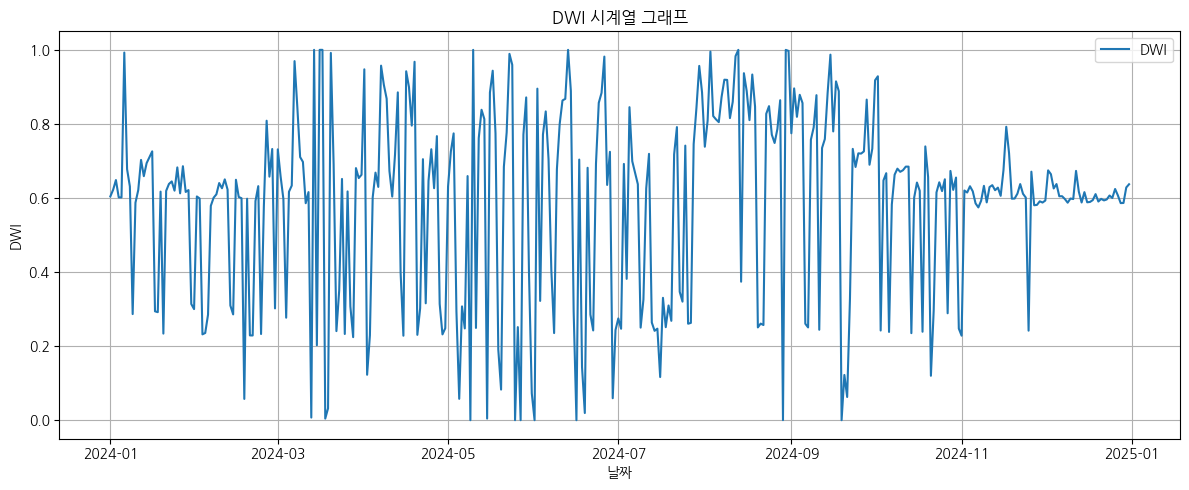

In [68]:
plt.figure(figsize=(12, 5))
plt.plot(gojeon_df['날짜'], gojeon_df['DWI'], label='DWI')

plt.title('DWI 시계열 그래프')
plt.xlabel('날짜')
plt.ylabel('DWI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()